## Import Library

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import random
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
import copy

## Problem properties

### Parametre: L'air

In [ ]:
#l'air
rho= 1.2
mu=  1.8*10**-5
D= 0.5
L= 2.5
u_in=0.5*10**-1
c_p=1005
l=0.0257
t_in=300
t_BC=400


rho1=rho
mu1=mu
c_p1=c_p
l1=l


u1=u_in
L1=2*D
T1=t_BC
T0=t_in
Re=2000/3
#Re=(rho1*u1*L1)/mu1
Pr= (mu*c_p)/l
print(Re)


666.6666666666666


## Define Network and Hyper-parameters

In [ ]:
NN = tf.keras.models.Sequential([
    #Number of variable input: 2 (x,y)
    tf.keras.layers.Input((2,)),

    #Define layer of neurone network
    tf.keras.layers.Dense(units = 64, activation = 'tanh'),
    tf.keras.layers.Dense(units = 64, activation = 'tanh'),
    tf.keras.layers.Dense(units = 64, activation = 'tanh'),
    tf.keras.layers.Dense(units = 64, activation = 'tanh'),

    #Number of variable output: 4 (u,v,p,t)
    tf.keras.layers.Dense(units = 4)
])

NN.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_10 (Dense)            (None, 64)                192       
                                                                 
 dense_11 (Dense)            (None, 64)                4160      
                                                                 
 dense_12 (Dense)            (None, 64)                4160      
                                                                 
 dense_13 (Dense)            (None, 64)                4160      
                                                                 
 dense_14 (Dense)            (None, 4)                 260       
                                                                 
Total params: 12932 (50.52 KB)
Trainable params: 12932 (50.52 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### Méthode pour optimiser NN

In [ ]:
optm = tf.keras.optimizers.Adam(learning_rate = 0.001)

## Define loss function

In [ ]:
def pde_loss(x, y, net, Re, Pr):
    x = x.reshape(-1,1)
    x = tf.constant(x, dtype = tf.float32)
    y = y.reshape(-1,1)
    y = tf.constant(y, dtype = tf.float32)


    # Compute derivatives
    with tf.GradientTape(persistent=True) as g:
        g.watch(x)
        g.watch(y)

        with tf.GradientTape() as gg:
            gg.watch(x)
            gg.watch(y)

            u = net(tf.concat([x, y], axis=1))[:,0]
        u_x, u_y = g.gradient(u, [x, y])
    u_xx = g.gradient(u_x, x)
    u_yy = g.gradient(u_y, y)

    with tf.GradientTape(persistent=True) as g:
        g.watch(x)
        g.watch(y)

        with tf.GradientTape() as gg:
            gg.watch(x)
            gg.watch(y)

            v = net(tf.concat([x, y], axis=1))[:,1]
        v_x, v_y = g.gradient(v, [x, y])
    v_xx = g.gradient(v_x, x)
    v_yy = g.gradient(v_y, y)

    with tf.GradientTape(persistent=True) as g:
        g.watch(x)
        g.watch(y)

        with tf.GradientTape() as gg:
            gg.watch(x)
            gg.watch(y)

            t = net(tf.concat([x, y], axis=1))[:,3]
        t_x, t_y = g.gradient(t, [x, y])
    t_xx = g.gradient(t_x, x)
    t_yy = g.gradient(t_y, y)

    with tf.GradientTape() as g:
        g.watch(x)
        g.watch(y)

        p = net(tf.concat([x, y], axis=1))[:,2]
        p_x, p_y = g.gradient(p, [x, y])


    # Compute PDE terms
    pde_u = u * u_x + v * u_y  + p_x - 1/Re * (u_xx + u_yy )
    pde_v = u * v_x + v * v_y  + p_y - 1/Re * (v_xx + v_yy )
    pde_t = u * t_x + v*t_y - (t_xx+t_yy) / (Re*Pr)
    pde_0 = u_x+ v_y


    # Compute square loss

    total_loss = tf.reduce_mean(tf.square(pde_u))+tf.reduce_mean(tf.square(pde_v))+tf.reduce_mean(tf.square(pde_0))+tf.reduce_mean(tf.square(pde_t))

    return total_loss
def BC_loss(x, y, net, t_BC):
    x = x.reshape(-1,1)
    x = tf.constant(x, dtype = tf.float32)
    y = y.reshape(-1,1)
    y = tf.constant(y, dtype = tf.float32)

    # Compute boundary conditions
    # At the cylinder body
    bc_u =  net(tf.concat([x, y], axis=1))[:,0]
    bc_v =  net(tf.concat([x, y], axis=1))[:,1]
    bc_t =  net(tf.concat([x, y], axis=1))[:,3] - 1


    total_loss = tf.reduce_mean(tf.square(bc_u))+tf.reduce_mean(tf.square(bc_v))+tf.reduce_mean(tf.square(bc_t))

    return total_loss


def IN_loss(x, y, net, u_in, t_in):

    x = x.reshape(-1,1)
    x = tf.constant(x, dtype = tf.float32)
    y = y.reshape(-1,1)
    y = tf.constant(y, dtype = tf.float32)


    # At the inlet
    bc_inlet_u = net(tf.concat([x, y], axis=1))[:,0] - 1
    bc_inlet_v = net(tf.concat([x, y], axis=1))[:,1]
    bc_inlet_t = net(tf.concat([x, y], axis=1))[:,3] - 0


    total_loss = tf.reduce_mean(tf.square(bc_inlet_u)) +tf.reduce_mean(tf.square(bc_inlet_v)) + tf.reduce_mean(tf.square(bc_inlet_t))
    return total_loss
def OUT_loss(x, y, net):
    x = x.reshape(-1,1)
    x = tf.constant(x, dtype = tf.float32)
    y = y.reshape(-1,1)
    y = tf.constant(y, dtype = tf.float32)

    # At the outlet
    bc_outlet_p = net(tf.concat([x, y], axis=1))[:,2]
    square_loss= tf.square(bc_outlet_p)
    total_loss = tf.reduce_mean(square_loss)
    return total_loss

## Generer des points pour entrainer

### Fonction de generer

In [ ]:

"""def generate_points_pde(L, D, N_pde):
    alpha = 0.5
    beta = 0.5
    points = []

    # Nombre des points pour chaqur distribution
    N_beta = N_pde // 2
    N_uniform = N_pde - N_beta

    # Beta distribution
    for _ in range(N_beta):
        x = (np.random.beta(alpha, beta) - 0.5) * L
        y = (np.random.beta(alpha, beta) - 0.5) * D
        points.append((x, y))

    # Uniform distribution
    for _ in range(N_uniform):
        x = random.uniform(-L/2, L/2)
        y = random.uniform(-D/2, D/2)
        points.append((x, y))

    return np.array(points)"""

In [ ]:
def generate_points_pde(L, D, N_pde):
    points = []
    while len(points) < N_pde:
        x = random.uniform(-L/2, L/2)
        y = random.uniform(-D/2, D/2)
        points.append((x, y))
    return np.array(points)
def generate_points_inlet(L, D, N_in):
    points = []
    while len(points) < N_in:
        x = random.uniform(-L/2, -L/2+L/1000)
        y = random.uniform(-D/2, D/2)
        points.append((x, y))
    return np.array(points)
def generate_points_outlet(L, D, N_out):
    points = []
    while len(points) < N_out:
        x = random.uniform(L/2-L/1000, L/2)
        y = random.uniform(-D/2, D/2)
        points.append((x, y))
    return np.array(points)
def generate_points_BC(L, D, N_BC):
    points = []
    while len(points) < N_BC:
        if len(points) % 2 == 0:
            y = random.uniform(D/2 - D/1000, D/2)
        else:
            y = random.uniform(-D/2, -D/2 + D/1000)
        x = random.uniform(-L/2, L/2)
        points.append((x, y))
    return np.array(points)

### Génerer des points

In [ ]:
N_pde = 1000
train_pde = generate_points_pde(L, D, N_pde)
train_x_pde=train_pde[:,0]
train_y_pde=train_pde[:,1]
N_BC = 500
train_BC = generate_points_BC(L, D, N_BC)
train_x_BC=train_BC[:,0]
train_y_BC=train_BC[:,1]
N_in = 200
train_in = generate_points_inlet(L, D, N_in)
train_x_in=train_in[:,0]
train_y_in=train_in[:,1]
N_out = 200
train_out = generate_points_outlet(L, D, N_out)
train_x_out=train_out[:,0]
train_y_out=train_out[:,1]



### Afficher des points

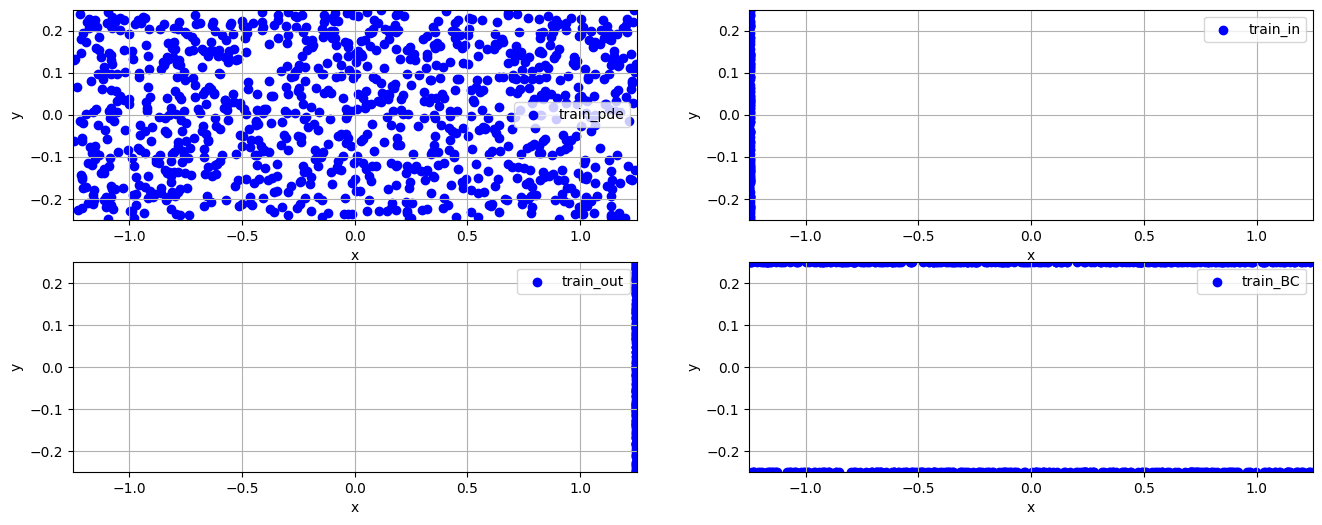

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(16, 6))


axs[0,0].scatter(train_x_pde, train_y_pde, color='b', marker='o', label='train_pde')
axs[0,0].set_xlabel('x')
axs[0,0].set_ylabel('y')
axs[0,0].set_xlim([-L/2, L/2])
axs[0,0].set_ylim([-D/2, D/2])
axs[0,0].grid(True)
axs[0,0].legend()


axs[0,1].scatter(train_x_in, train_y_in, color='b', marker='o', label='train_in')
axs[0,1].set_xlabel('x')
axs[0,1].set_ylabel('y')
axs[0,1].set_xlim([-L/2, L/2])
axs[0,1].set_ylim([-D/2, D/2])
axs[0,1].grid(True)
axs[0,1].legend()

axs[1,0].scatter(train_x_out, train_y_out, color='b', marker='o', label='train_out')
axs[1,0].set_xlabel('x')
axs[1,0].set_ylabel('y')
axs[1,0].set_xlim([-L/2, L/2])
axs[1,0].set_ylim([-D/2, D/2])
axs[1,0].grid(True)
axs[1,0].legend()


axs[1,1].scatter(train_x_BC, train_y_BC, color='b', marker='o', label='train_BC')
axs[1,1].set_xlabel('x')
axs[1,1].set_ylabel('y')
axs[1,1].set_xlim([-L/2, L/2])
axs[1,1].set_ylim([-D/2, D/2])
axs[1,1].grid(True)
axs[1,1].legend()


plt.show()

## Entrainer modele

In [ ]:
train_loss_record = []

In [ ]:

best_loss=np.ones(4)
best=1.0

for itr in range(6000):
    with tf.GradientTape() as tape:

        train_loss_BC= BC_loss (train_x_BC, train_y_BC, NN, t_BC)
        train_loss_IN= IN_loss (train_x_in, train_y_in, NN, u_in, t_in)

        train_loss_OUT= OUT_loss (train_x_out, train_y_out, NN)
        train_loss_pde = pde_loss(train_x_pde, train_y_pde, NN, Re, Pr)
        total_loss =  train_loss_BC + train_loss_IN + train_loss_OUT +train_loss_pde

        train_loss_record.append(total_loss)

        grad_w = tape.gradient(total_loss, NN.trainable_variables)
        optm.apply_gradients(zip(grad_w, NN.trainable_variables))

    if train_loss_BC.numpy()< best_loss[0] and train_loss_IN.numpy()< best_loss[1] and train_loss_OUT.numpy()< best_loss[2] and train_loss_pde.numpy()< best_loss[3]:
        best_loss[0]=train_loss_BC.numpy()
        best_loss[1]=train_loss_IN.numpy()
        best_loss[2]=train_loss_OUT.numpy()
        best_loss[3]=train_loss_pde.numpy()
        NN_1 = copy.deepcopy(NN)
    if total_loss.numpy()< best:
        best=total_loss.numpy()
        NN_2 = copy.deepcopy(NN)

    if itr % 1000 == 999:
        print(train_loss_BC.numpy())
        print(train_loss_IN.numpy())
        print(train_loss_OUT.numpy())
        print(train_loss_pde.numpy())
        print(total_loss.numpy())
        print("---------------")
#plt.figure(figsize = (10,8))
#plt.plot(train_loss_record)
#plt.show()
print(train_loss_BC)

0.04034204
0.051834427
3.0011097e-06
0.030890413
0.12306988
---------------
0.0206562
0.02484902
6.1751844e-06
0.02974258
0.07525398
---------------
0.013037402
0.016404701
1.7468609e-06
0.01281966
0.04226351
---------------
0.010180903
0.011243939
8.7011017e-07
0.014205198
0.035630908
---------------
0.009489548
0.008053286
5.6094977e-06
0.015591047
0.033139493
---------------
0.00730522
0.0064955056
6.457906e-06
0.012603151
0.026410334
---------------
tf.Tensor(0.00730522, shape=(), dtype=float32)


### Afficher des figures

15625/15625 [==============================] - 23s 1ms/step


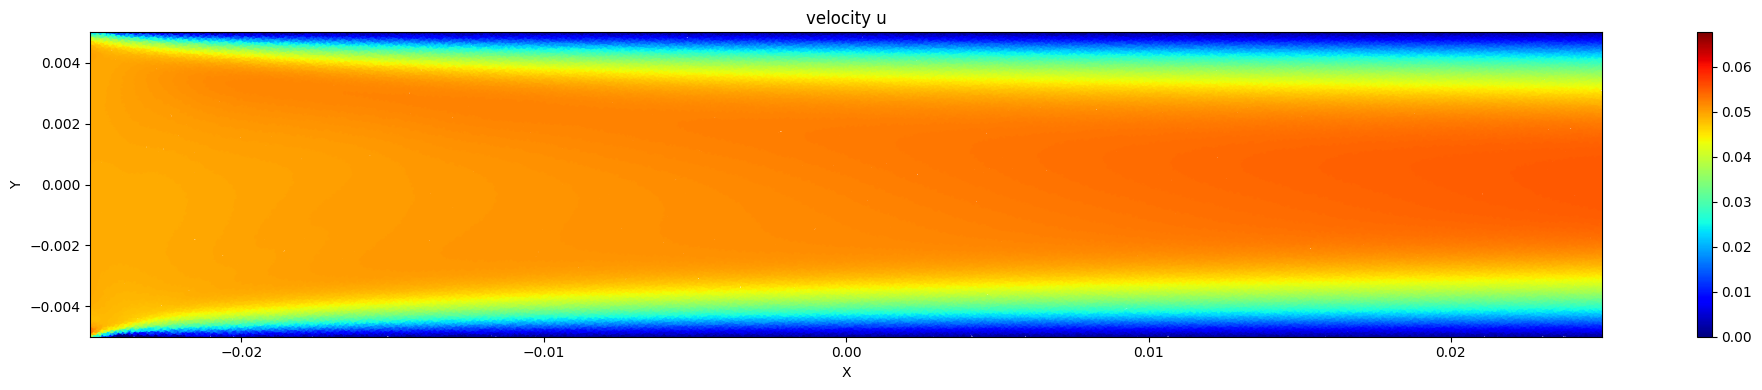

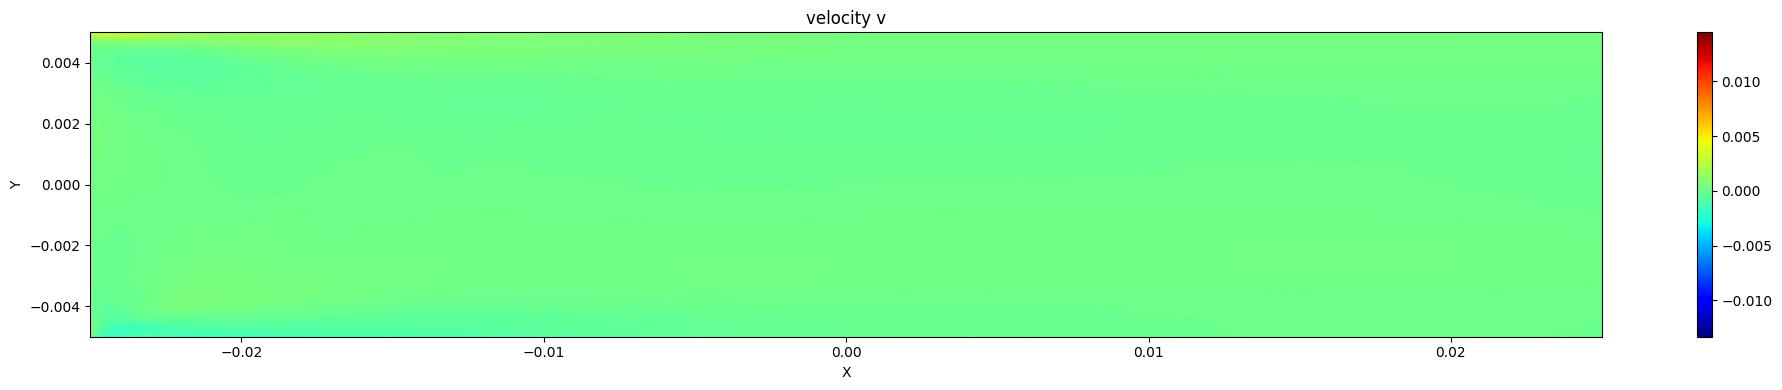

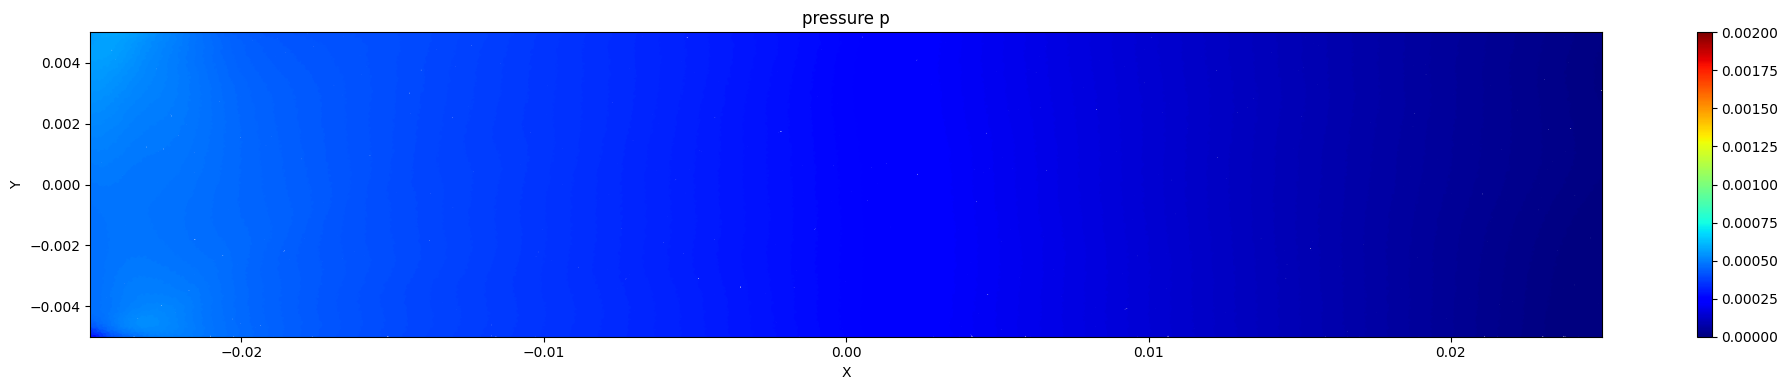

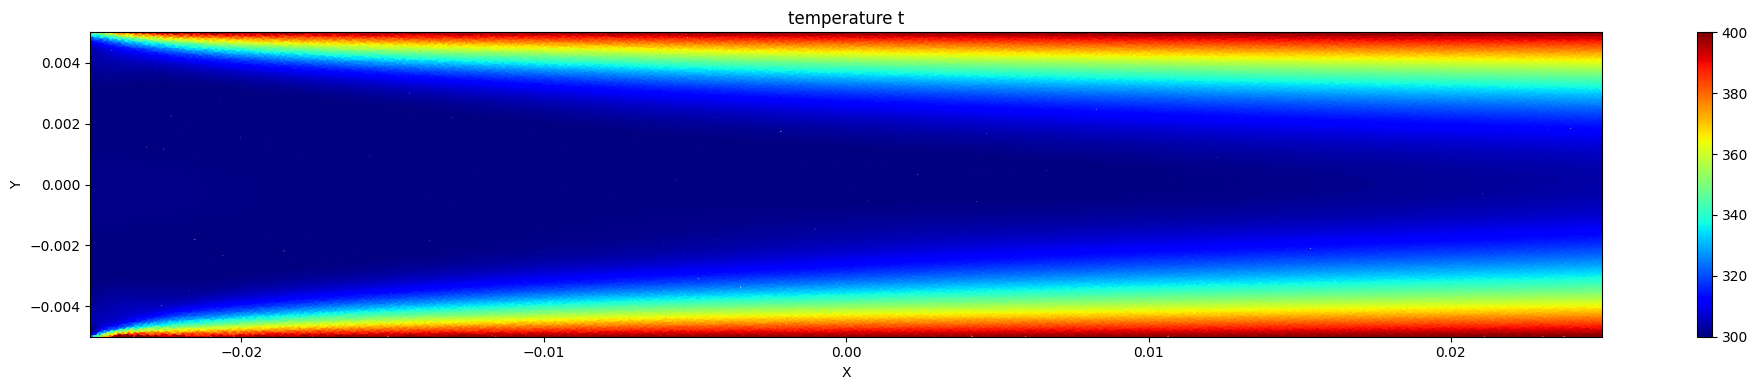

In [ ]:
samples = np.random.rand(500000, 2)
samples[:, 0] = (samples[:, 0] - 0.5) * L
samples[:, 1] = (samples[:, 1] - 0.5) * D

result = NN.predict(samples)

result[:,0]= result[:,0]*u1
result[:,1]= result[:,1]*u1
result[:,2]= result[:,2]*rho1*u1**2
result[:,3]= result[:,3]*(T1-T0)+T0
samples[:, 0]=samples[:, 0]*0.2
samples[:, 1]=samples[:, 1]*0.2
titles = ['velocity u', 'velocity v', 'pressure p', 'temperature t']
color_legend = [[0, 0.0676], [-0.01331, 0.01447], [0, 0.002],[300,400]]
for idx, title in enumerate(titles):
    plt.figure(figsize=(20, 4))
    plt.scatter(samples[:, 0],
                samples[:, 1],  # Assuming z coordinate is the third dimension
                c=result[:, idx],
                cmap='jet',
                s=2)
    plt.colorbar()
    plt.title(title)
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.clim(color_legend[idx])
    plt.xlim((0-L/2*0.2, L*0.2-L/2*0.2))
    plt.ylim((0-D/2*0.2, D*0.2-D/2*0.2))
    plt.tight_layout()
    plt.savefig(f'plot_{idx+1}_{title}.png')
    plt.show()